### Preparation

In [168]:
import cyvcf2
import pybedtools as pb
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['axes.titlesize'] = 18      
plt.rcParams['axes.labelsize'] = 16 
plt.rcParams['xtick.labelsize'] = 14  
plt.rcParams['ytick.labelsize'] = 14   
plt.rcParams['figure.titlesize'] = 20  
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 16

fig_out = "/lustre1/g/paed_yangwl/snakesch/work/svhet/plots"
table_out = "/lustre1/g/paed_yangwl/snakesch/work/svhet/tables"


In [2]:
raw_vc_sets = {
    "HG002": {
        "manta": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/illumina_60x/manta/results/variants/diploidSV.vcf.gz",
        "delly": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/illumina_60x/delly/HG002.delly.bcf",
        "lumpy": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/illumina_60x/lumpy/HG002.lumpy.gt.vcf.gz"
    },
    "HG003": {
        "manta": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG003/structural_variants/illumina_60x/manta/results/variants/diploidSV.vcf.gz",
        "delly": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG003/structural_variants/illumina_60x/delly/HG003.delly.bcf", 
        "lumpy": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG003/structural_variants/illumina_60x/lumpy/HG003.lumpy.gt.vcf.gz"
    },
    "HG004": {
        "manta": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG004/structural_variants/illumina_60x/manta/results/variants/diploidSV.vcf.gz",
        "delly": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG004/structural_variants/illumina_60x/delly/HG004.delly.bcf", 
        "lumpy": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG004/structural_variants/illumina_60x/lumpy/HG004.lumpy.gt.vcf.gz"
    }
}

benchmark_region_fp = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/benchmark_data/NIST_SVs_Integration_v0.6/HG002_SVs_Tier1_v0.6.bed"
bench_region = pb.BedTool(benchmark_region_fp)

In [3]:
def extract_variant_by_region(vcf, regions):
    '''
    Excludes:
    Variants with size < 50bp
    BND
    Allosomal SVs
    SVs not satisfying bench type   
    '''
    filtered_variants = {}
    for region in regions:
        chrom = region.chrom
        start = region.start + 1
        end = region.stop + 1
        
        chroms = list(map(str, range(1, 23)))
        
        if chrom not in chroms: ## Only include autosomal SVs 
            continue
        
        for variant in vcf(f"{chrom}:{start}-{end}"):
            if variant.INFO["SVTYPE"] == "BND":
                continue
            varsize = abs(variant.INFO.get("SVLEN") or variant.INFO.get("END") - variant.POS)
            if varsize < 50:
                continue
            
            if variant.INFO["SVTYPE"] != "DEL":
                if start <= variant.POS <= end:
                    filtered_variants[variant.ID] = variant
                continue

            if start < variant.POS < end or start < variant.end < end:
                filtered_variants[variant.ID] = variant
            elif variant.POS < start and variant.end > end:
                filtered_variants[variant.ID] = variant
                    
    return list(sorted(filtered_variants.values(), key=lambda x: (x.CHROM, x.POS)))

In [4]:
root = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/{}/structural_variants/either/illumina_150bp/{}/60x/"

samples = ["HG002", "HG003", "HG004"]
callers = ["manta", "delly", "lumpy"]


### SV distribution of 9 callsets

Figure S1. Distribution of structural variations (SVs) in 9 callsets derived from selected GIAB samples. We profiled SVs called from PE150 alignment files using Manta, DELLY and Lumpy. SVs without PASS filter tag or <50bp are excluded; only DEL and INS are excluded. 

In [162]:
from collections import Counter

count_df = {}

for sample in samples:
    for caller in callers:
        alias = f"{sample}-{caller}"
        raw_vcf = cyvcf2.VCF(raw_vc_sets[sample][caller], gts012=True)
        variants = extract_variant_by_region(raw_vcf, bench_region)
        variants = list(filter(lambda v: v.INFO["SVTYPE"] in ["DEL", "INS"] and v.FILTER is None and v.gt_types[0] in [1, 2], variants)) ## PASS variants, and inclyde HET and HOM variants
    
        variant_categories = [(v.INFO.get("SVTYPE"), v.gt_types[0]) for v in variants]
        count = Counter(variant_categories)
        count_df[alias] = count
        
        raw_vcf.close()

In [163]:
df = pd.DataFrame.from_dict(count_df, orient="index").fillna(0).astype(int)
df.columns = ["HOM DEL", "HET DEL", "HOM INS", "HET INS"] # ['{}_{}'.format(l0, l1) for l0, l1 in df.columns]
df = df.loc[:, ["HET DEL", "HOM DEL", "HET INS", "HOM INS"]]


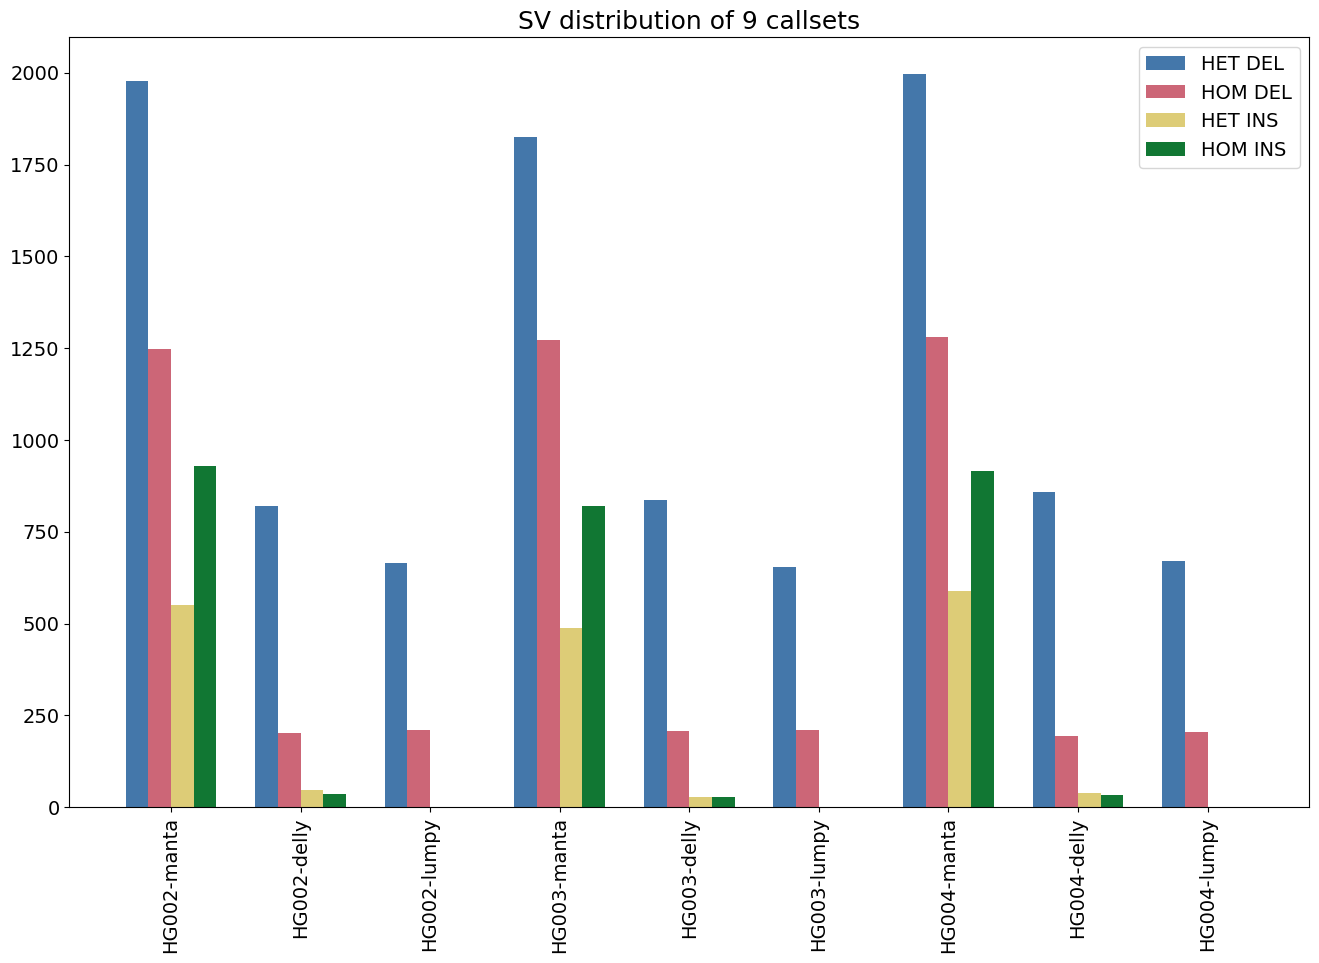

In [170]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

ind = np.arange(0, df.shape[0] * 2, 2)
width = .35

color_het_del = '#4477AA'  
color_hom_del = '#CC6677'  
color_het_ins = '#DDCC77'  
color_hom_ins = '#117733'

ax.bar(ind - 1.5 * width, df["HET DEL"], width, label="HET DEL", color=color_het_del, alpha=1.0)
ax.bar(ind - 0.5 * width, df["HOM DEL"], width, label="HOM DEL", color=color_hom_del, alpha=1.0)
ax.bar(ind + 0.5 * width, df["HET INS"], width, label="HET INS", color=color_het_ins, alpha=1.0)
ax.bar(ind + 1.5 * width, df["HOM INS"], width, label="HOM INS", color=color_hom_ins, alpha=1.0)

ax.set_xticks(ind)
ax.set_xticklabels(df.index, rotation=90)

ax.legend()
ax.set_title("SV distribution of 9 callsets")

plt.savefig(os.path.join(fig_out, "Figure S1.png"), dpi=300)

### SV distribution of 3 selected GIAB samples

In [171]:
HG002_raw_bench = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/benchmark_data/NIST_SVs_Integration_v0.6/HG002_SVs_Tier1_v0.6.vcf.gz"

raw_vcf = cyvcf2.VCF(HG002_raw_bench, gts012=True)

het_repr = ["0/1", "1/0", "0|1", "1|0"]

count_df = {}

variants = extract_variant_by_region(raw_vcf, bench_region)

HG002_variants = list(filter(lambda v: v.FILTER is None and v.gt_types[0] in [1, 2], variants))
variant_categories = [(v.INFO.get("SVTYPE"), "HET" if v.gt_types[0] == 1 else "HOM") for v in HG002_variants] ## True -> HET, False -> HOM
HG002_count = Counter(variant_categories)
count_df["HG002"] = HG002_count

HG003_variants = list(filter(lambda v: "." not in v.INFO["HG003_GT"] and v.FILTER != "lt50bp", variants)) ## Exclude missing genotypes
variant_categories = [(v.INFO.get("SVTYPE"), "HET" if v.INFO["HG003_GT"] in het_repr else "HOM") for v in HG003_variants] ## True -> HET, False -> HOM
HG003_count = Counter(variant_categories)
count_df["HG003"] = HG003_count

HG004_variants = list(filter(lambda v: "." not in v.INFO["HG004_GT"] and v.FILTER != "lt50bp", variants))
variant_categories = [(v.INFO.get("SVTYPE"), "HET" if v.INFO["HG004_GT"] in het_repr else "HOM") for v in HG004_variants]
HG004_count = Counter(variant_categories)
count_df["HG004"] = HG004_count

raw_vcf.close()

In [172]:
df = pd.DataFrame.from_dict(count_df, orient="index").fillna(0).astype(int)
df.columns = ["HOM DEL", "HOM INS", "HET INS", "HET DEL"]
df = df.loc[:, ["HET DEL", "HOM DEL", "HET INS", "HOM INS"]]
df


,HET DEL,HOM DEL,HET INS,HOM INS
HG002,2608,1569,2631,2652
HG003,2458,3651,2285,3661
HG004,2552,3526,2359,3518


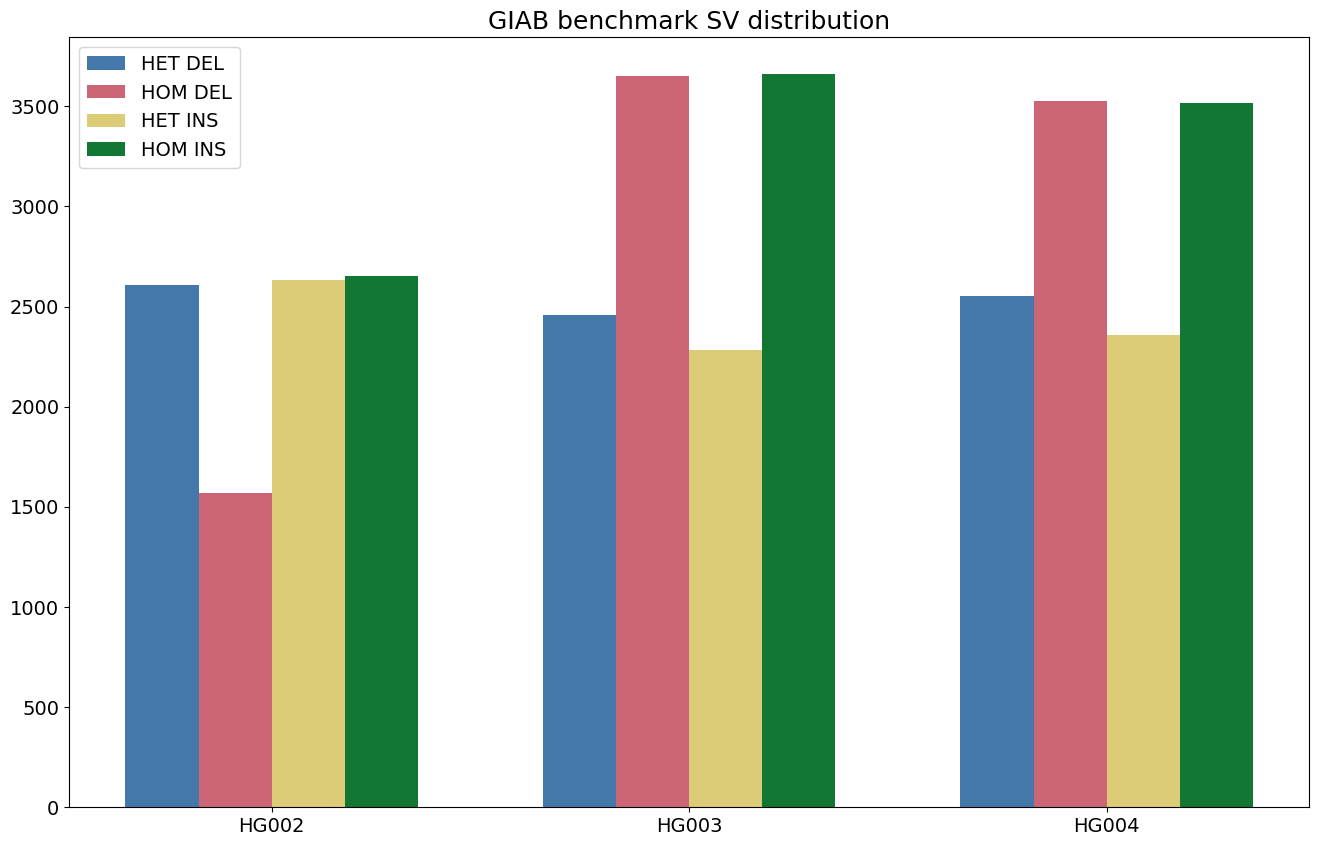

In [177]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

ind = np.arange(0, df.shape[0] * 2, 2)
width = .35

color_het_del = '#4477AA'  
color_hom_del = '#CC6677'  
color_het_ins = '#DDCC77'  
color_hom_ins = '#117733'

ax.bar(ind - 1.5 * width, df["HET DEL"], width, label="HET DEL", color=color_het_del, alpha=1.0)
ax.bar(ind - 0.5 * width, df["HOM DEL"], width, label="HOM DEL", color=color_hom_del, alpha=1.0)
ax.bar(ind + 0.5 * width, df["HET INS"], width, label="HET INS", color=color_het_ins, alpha=1.0)
ax.bar(ind + 1.5 * width, df["HOM INS"], width, label="HOM INS", color=color_hom_ins, alpha=1.0)

ax.set_xticks(ind)
ax.set_xticklabels(df.index, rotation=0)

ax.set_title("GIAB benchmark SV distribution")
ax.legend()

plt.savefig(os.path.join(fig_out, 'Figure S2.png'), dpi=300)

### Length distribution of benchmark heterozygous deletions


In [178]:
def get_sizes(vcf_fp):
    vcf = cyvcf2.VCF(vcf_fp, gts012=True) ## only heterozygous deletions here
    sizes = []
    for variant in vcf():
        varsize = abs(variant.INFO.get("SVLEN") or variant.INFO.get("END") - variant.POS)
        sizes.append(varsize)
    vcf.close()
    return sizes

def get_category_counts(sizes):
    categories = {"50to500": 0, "500to5000": 0, "gt5000": 0}
    for varsize in sizes:
        if 50 <= varsize < 500:
            categories["50to500"] += 1
        elif 500 <= varsize < 5000:
            categories["500to5000"] += 1
        elif varsize >= 5000:
            categories["gt5000"] += 1
            
    return categories

def plot_stacked_bar(size_cat, ax):
    
    width = 0.1
    bar_colors = ['#3274A1', '#E1812C', '#3A923A']  # blue, orange, green
    
    p1 = ax.bar(0, size_cat["50to500"], width, label='50-500', color=bar_colors[0])
    p2 = ax.bar(0, size_cat["500to5000"], width, bottom=size_cat["50to500"], 
               label='500-5000', color=bar_colors[1])
    p3 = ax.bar(0, size_cat["gt5000"], width, 
               bottom=size_cat["50to500"] + size_cat["500to5000"], 
               label='>5000', color=bar_colors[2])
    
    # Add total count on top of bar
    total = sum(size_cat.values())
    ax.text(0, total + 0.5, str(total), ha='center', fontsize=10)
    
    ax.get_xaxis().set_visible(False)
    for loc in ['top', 'right', 'bottom']:
        ax.spines[loc].set_visible(False)

    return ax

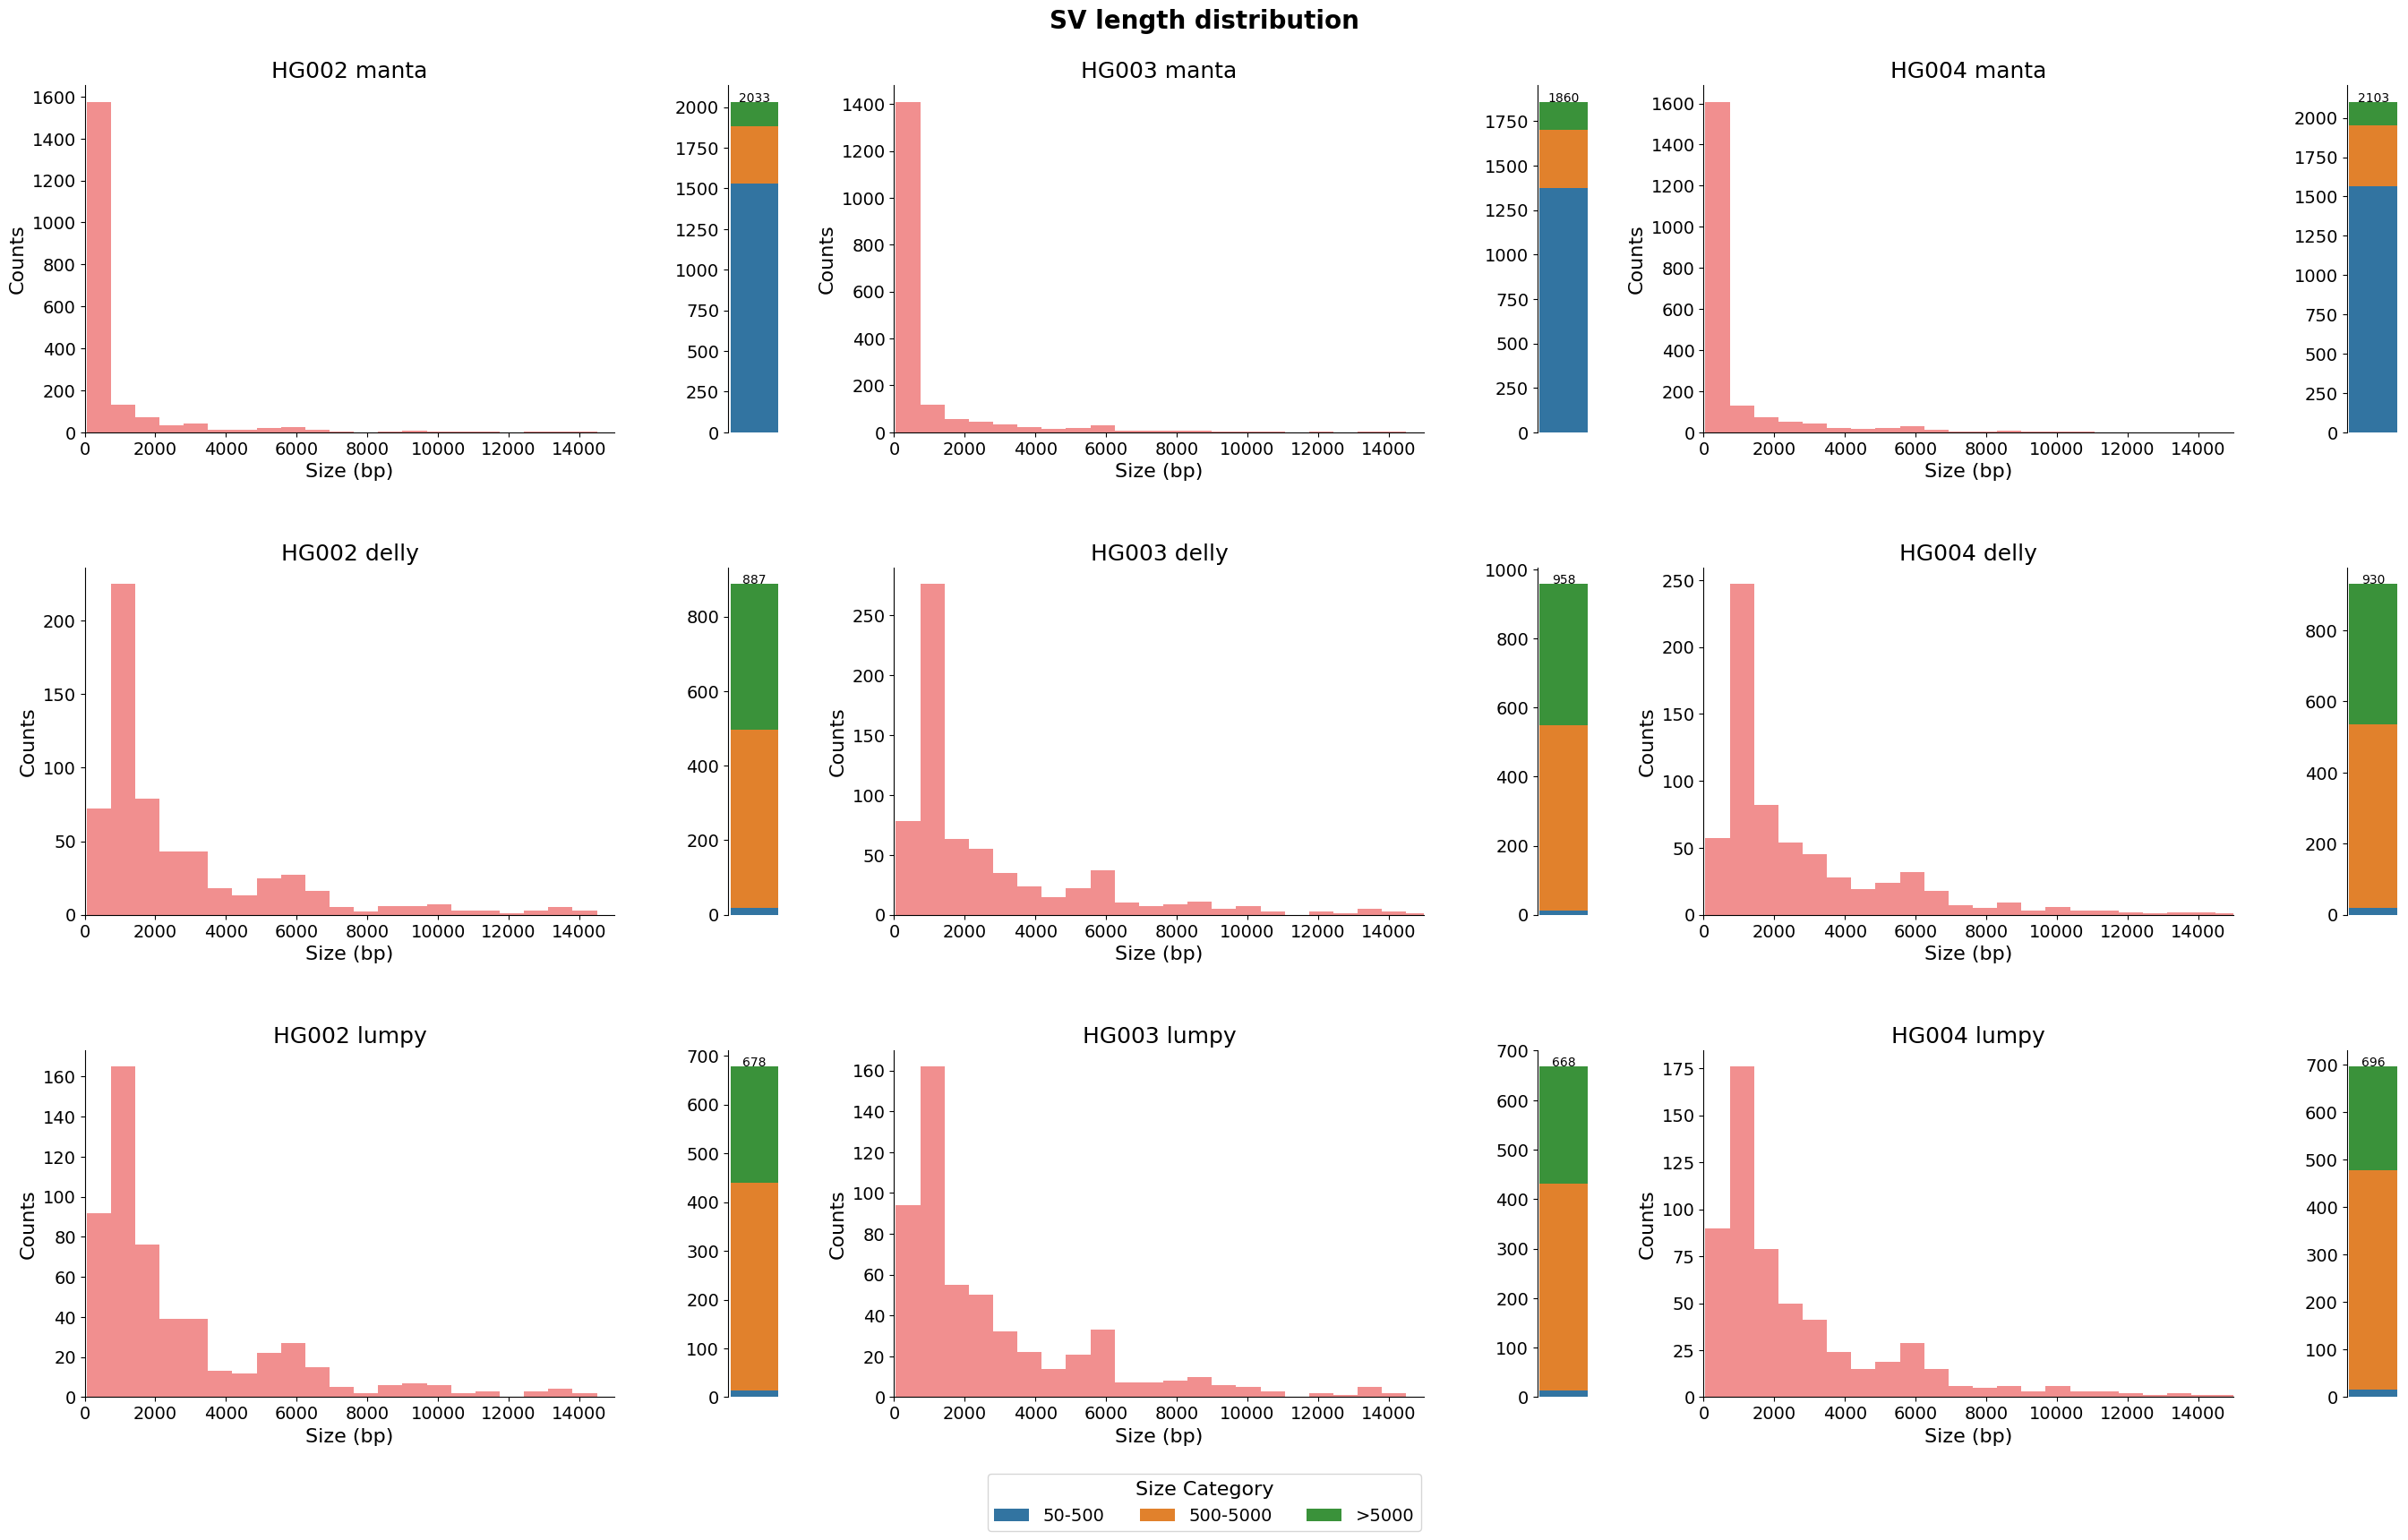

In [180]:
root = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/{}/structural_variants/either/illumina_150bp/{}/60x/"

plt.rcParams['axes.titlesize'] = 18      
plt.rcParams['axes.labelsize'] = 16 
plt.rcParams['xtick.labelsize'] = 14  
plt.rcParams['ytick.labelsize'] = 14   
plt.rcParams['figure.titlesize'] = 20  
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 16

fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(30, 18), width_ratios=[1, 0.1, 1, 0.1, 1, 0.1])
fig.subplots_adjust(hspace=1.2, wspace=0.5)
fig.suptitle("SV length distribution", fontweight="bold", y=0.95)

sample_idx = 0
for sample in samples:
    caller_idx = 0
    for caller in callers:
        candidates = os.path.join(root.format(sample, caller), "candidates.vcf.gz")
        sizes = get_sizes(candidates)
        cat = get_category_counts(sizes)

        bins = np.linspace(50, 20000, 30)
        ax = axes[caller_idx, sample_idx * 2]
        ax.hist(sizes, bins=bins, alpha=0.88, color='#F08080')
        ax.set_xlim(0, 15000)
        ax.set_xlabel("Size (bp)")
        ax.set_ylabel("Counts")
        ax.set_title(f"{sample} {caller}")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        plot_stacked_bar(cat, axes[caller_idx, sample_idx * 2 + 1])
        caller_idx += 1
    sample_idx += 1

handles, labels = axes[0,1].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='lower center', title='Size Category', ncols=3)
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95], h_pad=5, w_pad=3)

plt.savefig(os.path.join(fig_out, 'Figure S3.png'), dpi=300)

### Length distribution of GIAB deletions

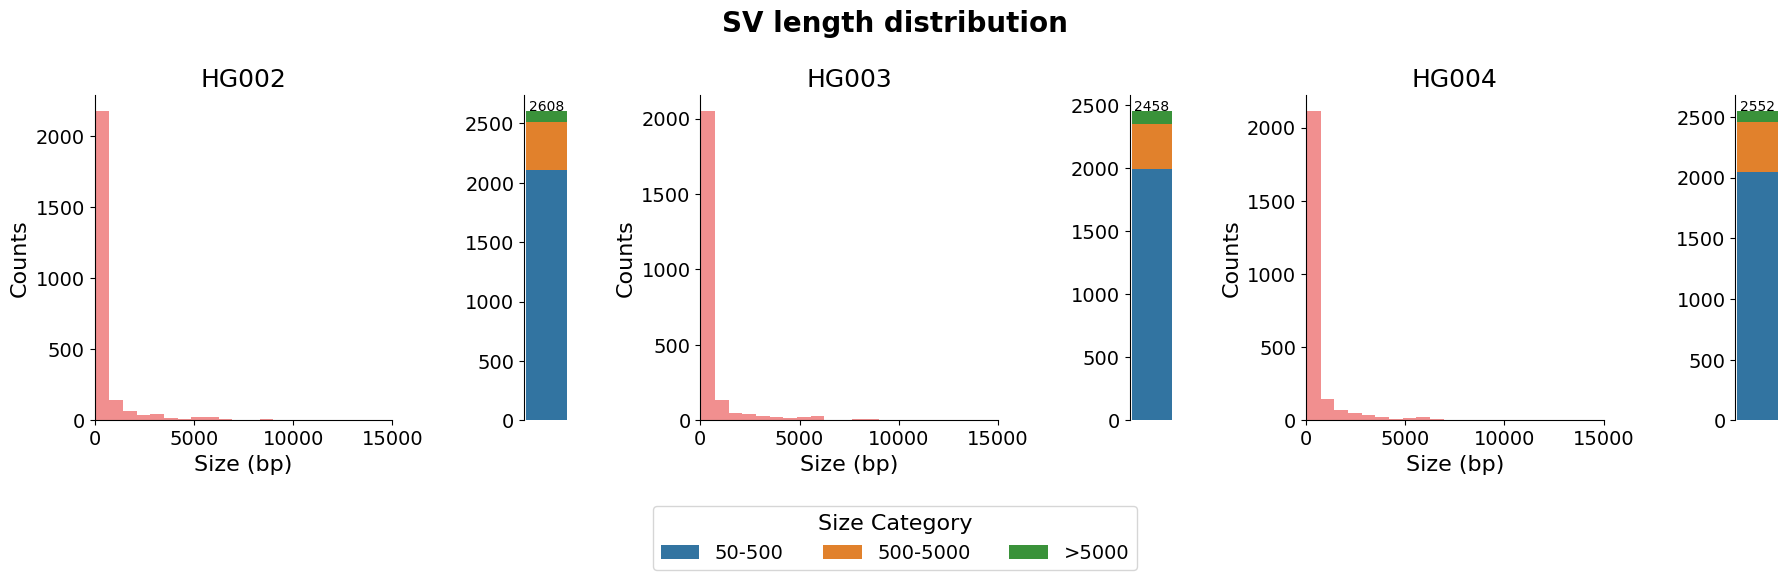

In [182]:
root = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/{}/structural_variants/benchmark_data/either/either_bench_vcf.gz"

plt.rcParams['axes.titlesize'] = 18      
plt.rcParams['axes.labelsize'] = 16 
plt.rcParams['xtick.labelsize'] = 14  
plt.rcParams['ytick.labelsize'] = 14   
plt.rcParams['figure.titlesize'] = 20  
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 16

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 6), width_ratios=[1, 0.15, 1, 0.15, 1, 0.15])
fig.subplots_adjust(hspace=1.2, wspace=0.5)
fig.suptitle("SV length distribution", fontweight="bold", y=0.95)

sample_idx = 0
for sample in samples:
    candidates = os.path.join(root.format(sample))
    sizes = get_sizes(candidates)
    cat = get_category_counts(sizes)

    bins = np.linspace(50, 20000, 30)
    ax = axes[sample_idx * 2]
    ax.hist(sizes, bins=bins, alpha=0.88, color='#F08080')
    ax.set_xlim(0, 15000)
    ax.set_xlabel("Size (bp)")
    ax.set_ylabel("Counts")
    ax.set_title(f"{sample}")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plot_stacked_bar(cat, axes[sample_idx * 2 + 1])
    sample_idx += 1

handles, labels = axes[1].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='lower center', title='Size Category', ncols=3)
fig.tight_layout(rect=[0.05, 0.15, 0.95, 0.95], h_pad=5, w_pad=3)
plt.savefig(os.path.join(fig_out, 'Figure S4.png'), dpi=300)

### Breakpoint uncertainty plot


In [184]:
root = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/{}/structural_variants/either/illumina_150bp/{}/60x/"

uncertainty_dict = {}
for sample in samples:
    for caller in callers:
        uncertainty_dict.setdefault(sample, {}).setdefault(caller, {})
        candidates = os.path.join(root.format(sample, caller), "candidates.vcf.gz")
        caller_vcf = cyvcf2.VCF(candidates)
        called_variants = list(caller_vcf())
        
        tags = ["CIPOS", "CIEND", "CIPOS95", "CIEND95"] 
        for tag in tags:
            uncertainty_dict[sample][caller][tag] = []
            if not caller_vcf.contains(tag):
                continue
            for variant in called_variants:
                total_uncertainty = sum(map(abs, variant.INFO.get(tag, (0,0))))
                uncertainty_dict[sample][caller][tag].append(total_uncertainty)      
        caller_vcf.close()

plot_data = []
for sample in samples:
    for caller in callers:
        for tag in ["CIPOS", "CIEND", "CIPOS95", "CIEND95"]:
            for val in uncertainty_dict[sample][caller].get(tag, None):
                if val is None:
                    continue
                if tag.endswith("95"):
                    callset_alias = f"{sample} {caller} (95% CI)"
                else:
                    callset_alias = f"{sample} {caller}"
                plot_data.append({
                    'Callset': callset_alias,
                    'Tag': tag.removesuffix("95"),
                    'Uncertainty': val
                })

df = pd.DataFrame(plot_data)


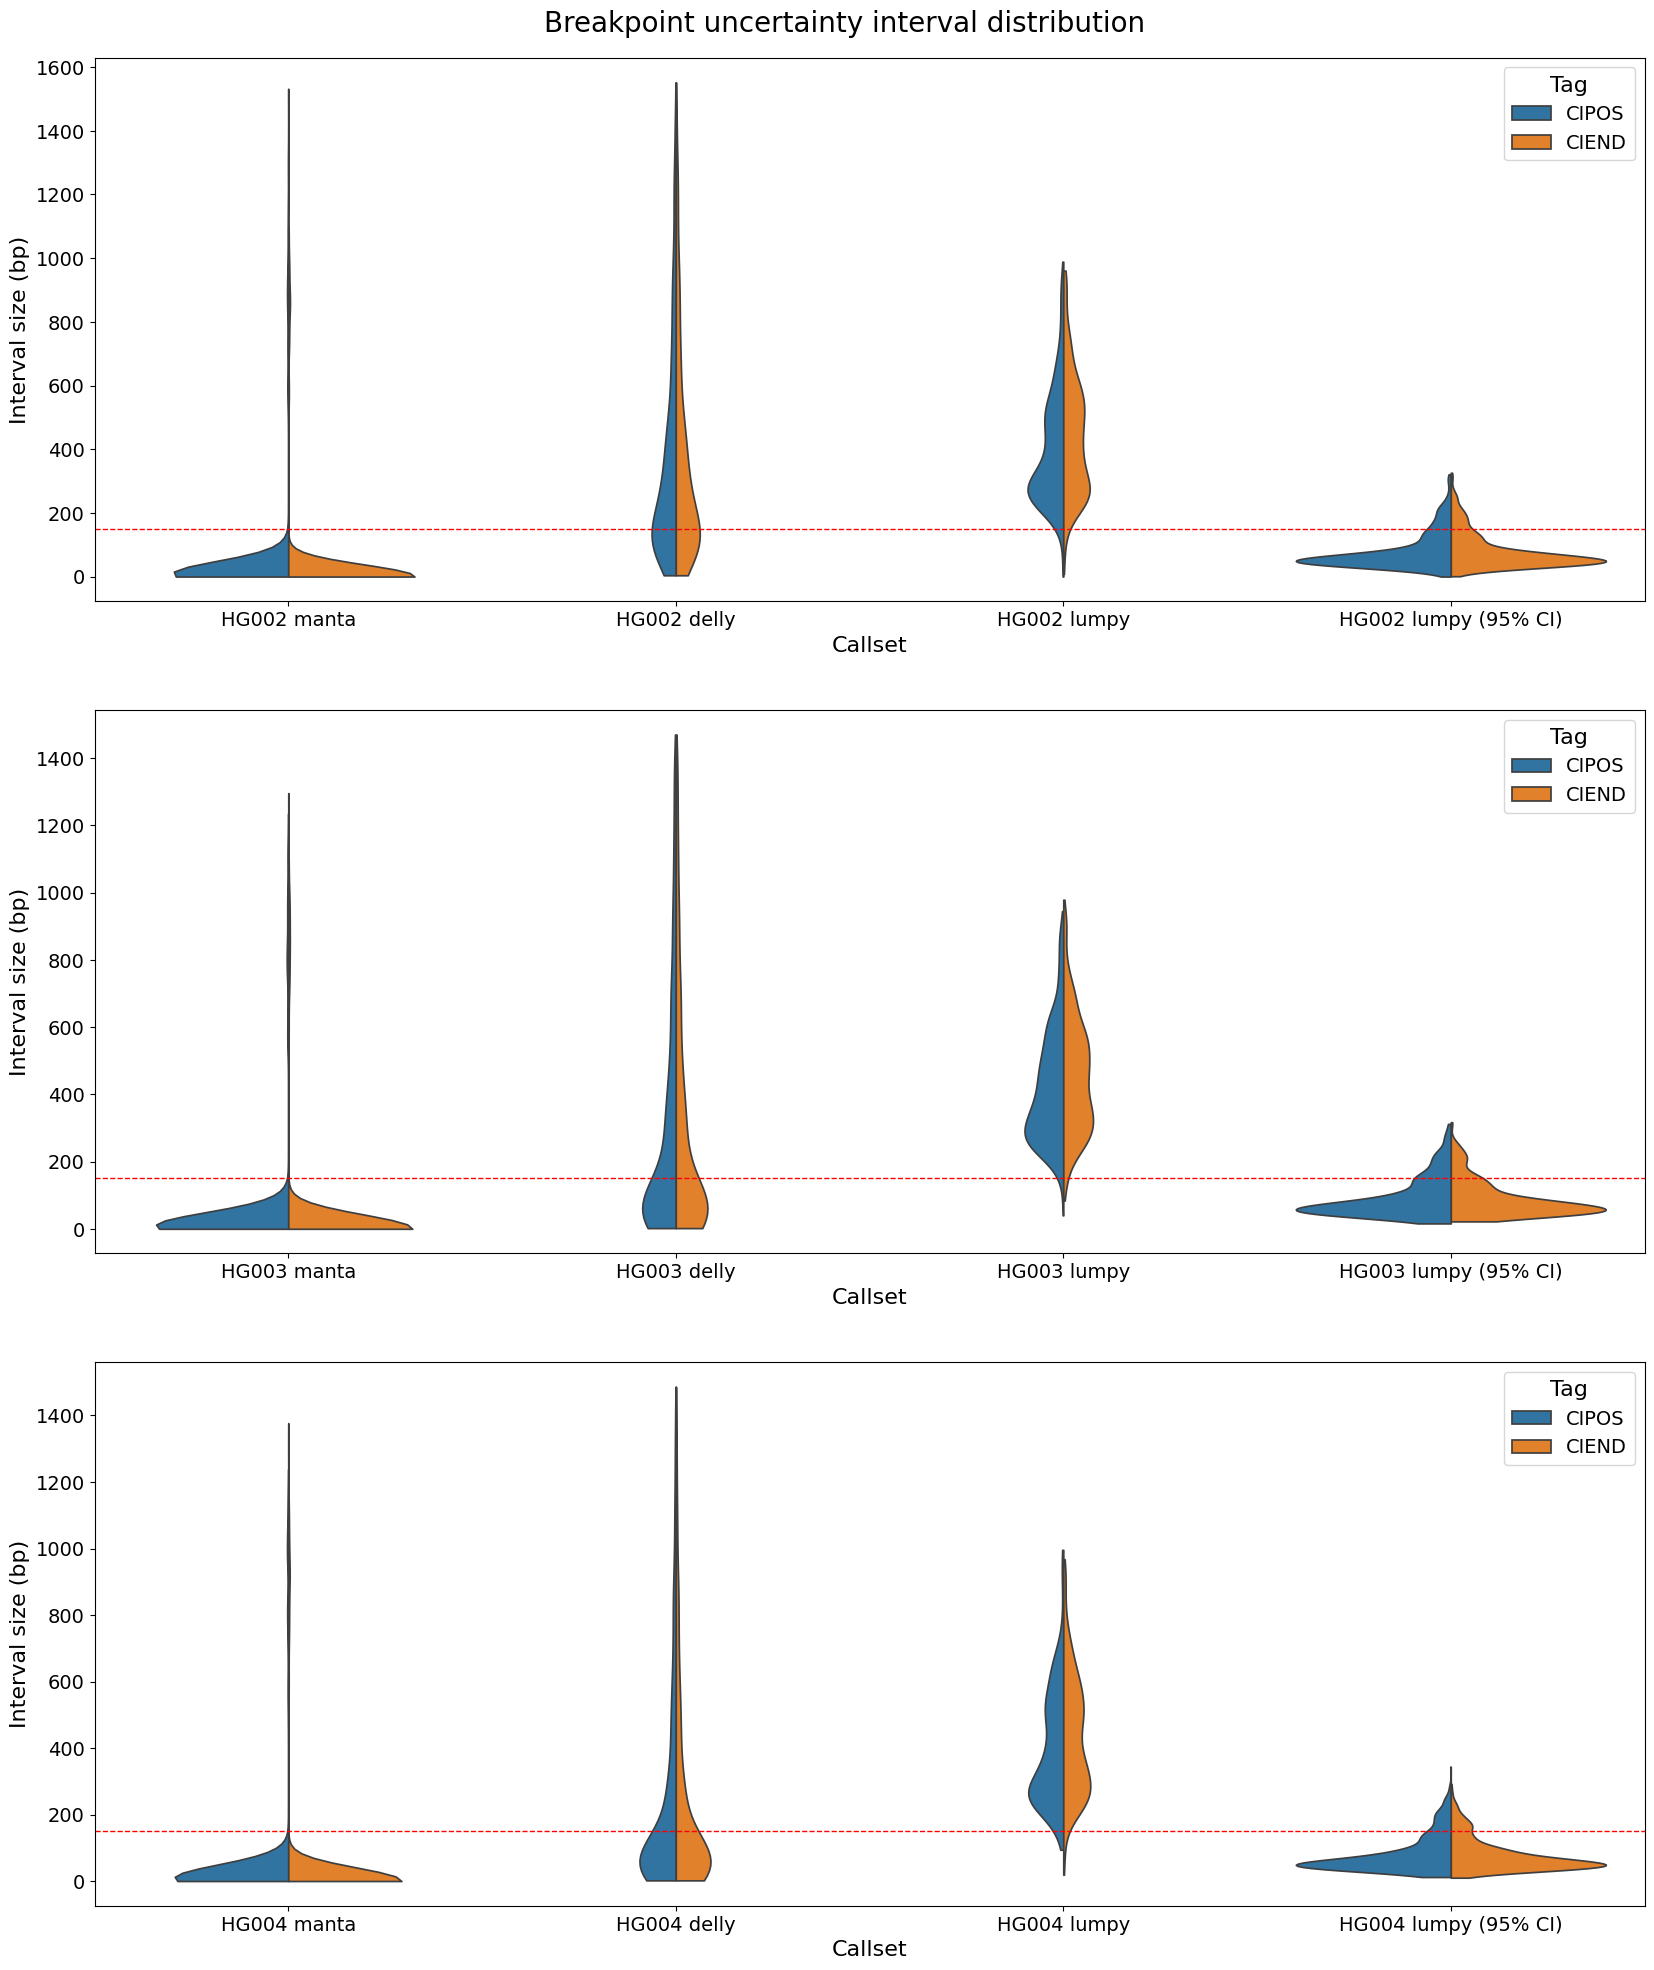

In [185]:
import seaborn as sns

## Plot
plt.rcParams['axes.titlesize'] = 18      
plt.rcParams['axes.labelsize'] = 16 
plt.rcParams['xtick.labelsize'] = 14  
plt.rcParams['ytick.labelsize'] = 14   
plt.rcParams['figure.titlesize'] = 20  
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 16

fig, axes = plt.subplots(3, 1, figsize=(20, 24))

fig.suptitle("Breakpoint uncertainty interval distribution", y=0.9)

for idx, sample in enumerate(samples):
    ax = axes[idx]
    sns.violinplot(x='Callset', y='Uncertainty', hue='Tag', data=df[df["Callset"].str.contains(sample)], ax=ax, split=True, cut=0, inner=None)
    ax.set_ylabel("Interval size (bp)")
    ax.axhline(y=150, color='red', linestyle='--', linewidth=1)

plt.savefig(os.path.join(fig_out, 'Figure S5.png'), dpi=300)


### Benchmarking

In [130]:
import sys
import pysam

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))
from benchmark import benchmark_callsets
giab_tier1_bench = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/benchmark_data/NIST_SVs_Integration_v0.6/HG002_SVs_Tier1_v0.6.vcf.gz"

root = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/{}/structural_variants/either/illumina_150bp/{}/60x/"
bench_root = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/{}/structural_variants/benchmark_data/either/either_bench_vcf.gz"

## Create filtered.bench.vcf.gz for efficient benchmarking
for sample in samples:
    for caller in callers:
        cur_root = root.format(sample, caller)
        bench_fp = bench_root.format(sample)
    
        candidate_fp = f"{cur_root}/candidates.vcf.gz"
        filtered_fp = f"{cur_root}/filtered.vcf.gz"
        
        if not os.path.exists(f"{cur_root}/filtered.bench.vcf.gz"):
            cand_vcf = cyvcf2.VCF(candidate_fp)
            filtered_vcf = cyvcf2.VCF(filtered_fp)
            out_vcf = cyvcf2.Writer(f"{cur_root}/filtered.bench.vcf.gz", filtered_vcf, mode='wz')
            
            var_ids = [v.ID for v in cand_vcf()]
            for v in filtered_vcf():
                if v.ID in var_ids:
                    out_vcf.write_record(v)
            
            cand_vcf.close()
            filtered_vcf.close()
            out_vcf.close()
        pysam.tabix_index(f"{cur_root}/filtered.bench.vcf.gz", preset="vcf", force=True)
    


In [189]:
## 1. Collect TP, FP and FN counts
## 2. Collect correctly and incorrectly rejected candidates
correct_dict, incorrect_dict = {}, {}
count = {}
for sample in samples:
    for caller in callers:
        cur_root = root.format(sample, caller)
        bench_fp = bench_root.format(sample)
    
        candidate_fp = f"{cur_root}/candidates.vcf.gz"
        filtered_fp = f"{cur_root}/filtered.bench.vcf.gz"

        _, tp_comp_old, fp_old, fn_old = benchmark_callsets(bench_fp, candidate_fp)
        _, tp_comp, fp, fn = benchmark_callsets(bench_fp, filtered_fp)
        
        correct_dict[f"{sample} {caller}"] = []
        incorrect_dict[f"{sample} {caller}"] = []
        count[f"{sample} {caller}"] = {}
        count[f"{sample} {caller}"]["before"] = {"tp": len(tp_comp_old), "fp": len(fp_old), "fn": len(fn_old)}
        count[f"{sample} {caller}"]["after"] = {"tp": len(tp_comp), "fp": len(fp), "fn": len(fn)}
                                                
        for ov in fp_old:
            found = False
            for nv in fp:
                if ov == nv:
                    found = True
                    break
            if not found:
                correct_dict[f"{sample} {caller}"].append(ov)
        
        for ov in tp_comp_old:
            found = False
            for nv in tp_comp:
                if ov == nv:
                    found = True
                    break
            if not found:
                incorrect_dict[f"{sample} {caller}"].append(ov)
        print(f"Done processing {sample} {caller} callset")

Total TP (comp): 1746
Total FP: 236
Total FN: 862
Total TP (comp): 1746
Total FP: 221
Total FN: 862
Done processing HG002 manta callset
Total TP (comp): 436
Total FP: 400
Total FN: 2172
Total TP (comp): 435
Total FP: 307
Total FN: 2173
Done processing HG002 delly callset
Total TP (comp): 446
Total FP: 232
Total FN: 2162
Total TP (comp): 445
Total FP: 180
Total FN: 2163
Done processing HG002 lumpy callset
Total TP (comp): 1571
Total FP: 259
Total FN: 887
Total TP (comp): 1571
Total FP: 236
Total FN: 887
Done processing HG003 manta callset
Total TP (comp): 416
Total FP: 439
Total FN: 2042
Total TP (comp): 416
Total FP: 343
Total FN: 2042
Done processing HG003 delly callset
Total TP (comp): 410
Total FP: 258
Total FN: 2048
Total TP (comp): 409
Total FP: 212
Total FN: 2049
Done processing HG003 lumpy callset
Total TP (comp): 1712
Total FP: 358
Total FN: 840
Total TP (comp): 1710
Total FP: 332
Total FN: 842
Done processing HG004 manta callset
Total TP (comp): 448
Total FP: 441
Total FN: 210

In [195]:
## Tabulate results 
count_df = pd.DataFrame.from_dict(count, orient="index")
count_df = pd.json_normalize(count_df["before"]).merge(pd.json_normalize(count_df["after"]), left_index=True, right_index=True, suffixes=("_before", "_after")).set_index(count_df.index)

count_df["Original Precision (%)"] = (count_df["tp_before"] / (count_df["tp_before"] + count_df["fp_before"]) * 100).round(2)
count_df["Original Recall (%)"] = (count_df["tp_before"] / (count_df["tp_before"] + count_df["fn_before"]) * 100).round(2)
count_df["Original F1 (%)"] = (2 / (1/count_df["Original Precision (%)"] + 1/count_df["Original Recall (%)"])).round(2)

count_df["SVhet Precision (%)"] = (count_df["tp_after"] / (count_df["tp_after"] + count_df["fp_after"]) * 100).round(2)
count_df["SVhet Recall (%)"] = (count_df["tp_after"] / (count_df["tp_after"] + count_df["fn_after"]) * 100).round(2)
count_df["SVhet F1 (%)"] = (2 / (1/count_df["SVhet Precision (%)"] + 1/count_df["SVhet Recall (%)"])).round(2)

count_df["Accuracy (%)"] = ((count_df["fp_before"] - count_df["fp_after"]) / (count_df["fp_before"] - count_df["fp_after"] + count_df["fn_after"] - count_df["fn_before"]) * 100).round(2)
count_df.columns = ['Original TP', 'Original FP', 'Original FN', 'SVhet TP', 'SVhet FP', 'SVhet FN',
                    'Original Precision (%)', 'Original Recall (%)', 'Original F1 (%)', 
                    'SVhet Precision (%)', 'SVhet Recall (%)', 'SVhet F1 (%)',
                    'Accuracy (%)']
count_df.iloc[:, [0,1,2,3,4,5,12]]


,Original TP,Original FP,Original FN,SVhet TP,SVhet FP,SVhet FN,Accuracy (%)
HG002 manta,1746,236,862,1746,221,862,100.00
HG002 delly,436,400,2172,435,307,2173,98.94
HG002 lumpy,446,232,2162,445,180,2163,98.11
HG003 manta,1571,259,887,1571,236,887,100.00
HG003 delly,416,439,2042,416,343,2042,100.00
HG003 lumpy,410,258,2048,409,212,2049,97.87
HG004 manta,1712,358,840,1710,332,842,92.86
HG004 delly,448,441,2104,447,350,2105,98.91
HG004 lumpy,449,247,2103,449,207,2103,100.00


In [226]:
test = count_df.iloc[:, [6,7,8,9,10,11]]
test.iloc[:, 1] - test.iloc[:, 4]
# test

HG002 manta    0.00
HG002 delly    0.04
HG002 lumpy    0.04
HG003 manta    0.00
HG003 delly    0.00
HG003 lumpy    0.04
HG004 manta    0.07
HG004 delly    0.03
HG004 lumpy    0.00
dtype: float64

In [161]:
assert correct_dict.keys() == incorrect_dict.keys()

def count_reasons(var_pool, *variants):
    reasons = {"wthap": 0, "muthap": 0, "het": 0}
    for v in variants:
        for pv in var_pool:
            if pv.CHROM == v[0] and pv.POS == v[1] and pv.REF == v[2] and pv.ALT[0] == v[3]:
                reasons[pv.FILTER] += 1
                break
    return reasons

all_results = {}
labels = []
for sample in samples:
    for caller in callers:
        cur_root = root.format(sample, caller)
        bench_fp = bench_root.format(sample)
    
        candidate_fp = f"{cur_root}/candidates.vcf.gz"
        filtered_fp = f"{cur_root}/filtered.bench.vcf.gz"

        filtered_vcf = cyvcf2.VCF(filtered_fp)
        variant_pool = list(filtered_vcf())
        
        cur_correct = [v[1] for v in correct_dict[f"{sample} {caller}"]]
        cur_incorrect = [v[1] for v in incorrect_dict[f"{sample} {caller}"]]

        all_results[f"{sample} {caller}"] = {}
        all_results[f"{sample} {caller}"]["correct"] = count_reasons(variant_pool, *cur_correct)
        all_results[f"{sample} {caller}"]["incorrect"] = count_reasons(variant_pool, *cur_incorrect)
                            
        filtered_vcf.close()

df = pd.DataFrame.from_dict(all_results, orient="index")
reason_df = pd.json_normalize(df["correct"]) \
                .merge(pd.json_normalize(df["incorrect"]), left_index=True, right_index=True, suffixes=("_correct", "_incorrect")) \
                .set_index(df.index)
reason_df


,wthap_correct,muthap_correct,het_correct,wthap_incorrect,muthap_incorrect,het_incorrect
HG002 manta,3,2,10,0,0,0
HG002 delly,0,0,93,1,0,0
HG002 lumpy,2,0,50,1,0,0
HG003 manta,2,1,20,0,0,0
HG003 delly,0,0,96,0,0,0
HG003 lumpy,4,0,42,1,0,0
HG004 manta,2,7,17,1,1,0
HG004 delly,2,0,89,1,0,0
HG004 lumpy,2,0,38,0,0,0


### Different coverages

In [197]:
callers = ["manta", "delly", "lumpy"]
depths = ["20x", "30x", "60x"]

root = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/either/illumina_150bp/{}/{}/" ## sample, caller, depth

reason_counts = {}
for caller in callers:
    for depth in depths:
        reason_counts.setdefault(caller, {}).setdefault(depth, {})
        reason_counts[caller][depth] = {"wthap": 0, "muthap": 0, "het": 0}
        
        cur_root = root.format(caller, depth)
        filtered_fp = f"{cur_root}/filtered.vcf.gz"
        
        filtered_vcf = cyvcf2.VCF(filtered_fp)
        
        for variant in filtered_vcf():
            if variant.FILTER in ["wthap", "muthap", "het"]:
                reason_counts[caller][depth][variant.FILTER] += 1
                
        filtered_vcf.close()

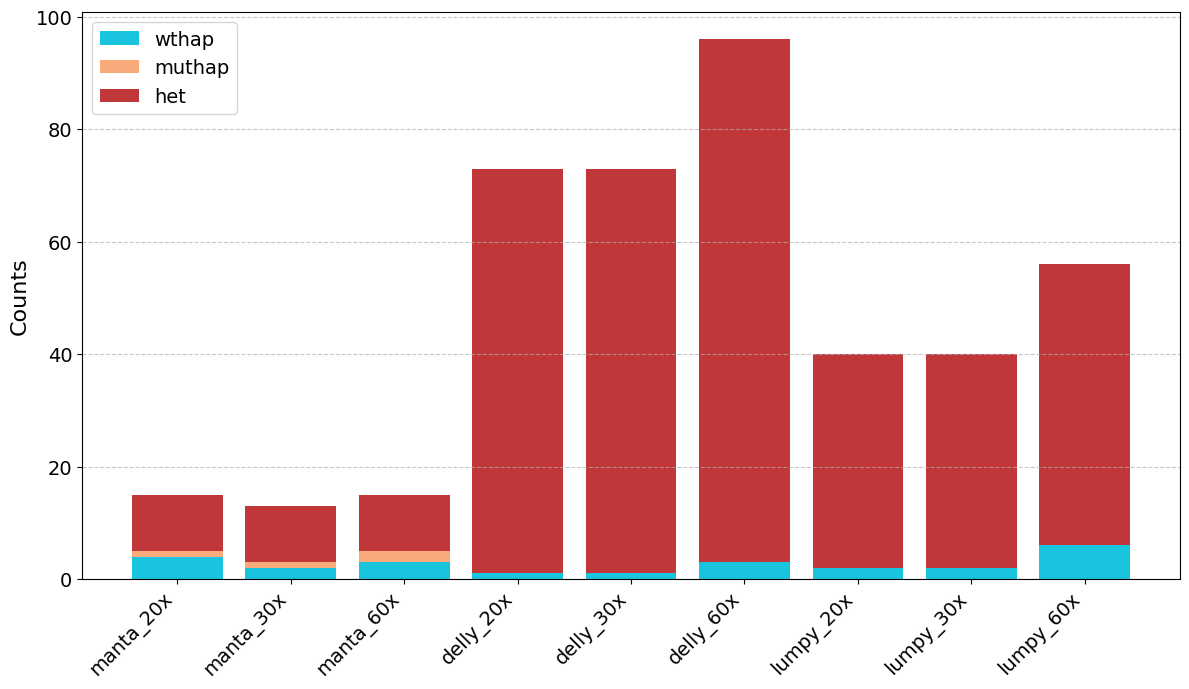

In [198]:
labels = [f"{caller}_{depth}" for caller in callers for depth in depths]
wthap_counts = [reason_counts[caller][depth]["wthap"] for caller in callers for depth in depths]
muthap_counts = [reason_counts[caller][depth]["muthap"] for caller in callers for depth in depths]
het_counts = [reason_counts[caller][depth]["het"] for caller in callers for depth in depths]

x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(x, wthap_counts, label='wthap', color='#18C4DE')
ax.bar(x, muthap_counts, bottom=wthap_counts, label='muthap', color='#F9AA7B')
bottom_het = np.array(wthap_counts) + np.array(muthap_counts)
ax.bar(x, het_counts, bottom=bottom_het, label='het', color='#C13639')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Counts')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(fig_out, 'Figure 3.png'), dpi=300, bbox_inches='tight')


### Comparison with Paragraph

In [26]:
## Build paragraph scripts
manifest_path = "/lustre1/g/paed_yangwl/snakesch/work/svhet/scripts/paragraph/manifest/HG002-illumina_150bp.txt"
paragraph_bin = "/lustre1/g/paed_yangwl/snakesch/tools/paragraph/bin/multigrmpy.py"
reference = "/group/paed_yangwl/hs37d5/hs37d5.fa"

script_path = os.path.join("/lustre1/g/paed_yangwl/snakesch/work/svhet/scripts/paragraph", "run_paragraph.sh")

callers = ["manta", "delly", "lumpy"]

with open(script_path, "w") as outfs:
    outfs.write("#!/bin/bash\n")
    for caller in callers:
        candidate_vcf_fp = f"/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/either/illumina_150bp/{caller}/60x/candidates.vcf.gz"
        outd = f"/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/either/illumina_150bp/{caller}/60x/paragraph/"
        os.makedirs(outd, exist_ok=True)
        
        if caller == "delly":
            ambiguous_id = "HG002.hs37d5.60x.1"
        else:
            ambiguous_id = "SAMPLE1"
        
        outfs.write(r"{ zgrep ^# " + candidate_vcf_fp + r" | sed -e 's/" + ambiguous_id + r"/HG002/g'; zgrep -v ^# " + candidate_vcf_fp + r"; } | bgzip -c > " + os.path.join(outd, "candidates.reheader.vcf.gz") + "\n")
        
        outfs.write(fr"{paragraph_bin} -r {reference} -m {manifest_path} ")
        outfs.write(fr"-i " + os.path.join(outd, "candidates.reheader.vcf.gz") + " ")
        outfs.write(fr"-o {outd} ")
        outfs.write("--threads 8 --verbose ")
        outfs.write("\n")
        
        paragraph_out = os.path.join(outd, "genotypes.vcf.gz")
        outfs.write(f"tabix -p vcf {paragraph_out}")
        outfs.write("\n")
        
        outfs.write(f"bcftools filter -i 'GT=\"het\"' -Wtbi -Oz -o {paragraph_out.replace('.vcf.gz', '.het.vcf.gz')} {paragraph_out}")
        outfs.write("\n")


In [199]:
## Benchmarking paragraph callsets

import sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))
from benchmark import benchmark_callsets

callers = ["manta", "delly", "lumpy"]

def classify_rejections(tp_old, tp_new, fp_old, fp_new):
    
    correct, incorrect = [], []
    for ov in tp_old:
        found = False
        for nv in tp_new:
            if ov == nv:
                found = True
                break
        if not found:
            incorrect.append(ov)
    
    for ov in fp_old:
        found = False
        for nv in fp_new:
            if ov == nv:
                found = True
                break
        if not found:
            correct.append(ov)
            
    return correct, incorrect

results = {}

for caller in callers:
    candidate_vcf_fp = f"/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/either/illumina_150bp/{caller}/60x/candidates.vcf.gz"
    svhet_vcf_fp = f"/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/either/illumina_150bp/{caller}/60x/filtered.bench.vcf.gz"
    paragraph_vcf_fp = f"/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/either/illumina_150bp/{caller}/60x/paragraph/genotypes.het.vcf.gz"
    either_bench_vcf_fp = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/benchmark_data/either/either_bench_vcf.gz"
    print("Caller: ", caller)
    results[caller] = {}
    _, tp_cand, fp_cand, fn_cand = benchmark_callsets(either_bench_vcf_fp, candidate_vcf_fp)
    _, tp_svhet, fp_svhet, fn_svhet = benchmark_callsets(either_bench_vcf_fp, svhet_vcf_fp)
    _, tp_paragraph, fp_paragraph, fn_paragraph = benchmark_callsets(either_bench_vcf_fp, paragraph_vcf_fp)
    
    results[caller]["tp-cand"] = len(tp_cand)
    results[caller]["fp-cand"] = len(fp_cand)
    results[caller]["fn-cand"] = len(fn_cand)
    results[caller]["tp-svhet"] = len(tp_svhet)
    results[caller]["fp-svhet"] = len(fp_svhet)
    results[caller]["fn-svhet"] = len(fn_svhet)
    results[caller]["tp-paragraph"] = len(tp_paragraph)
    results[caller]["fp-paragraph"] = len(fp_paragraph)
    results[caller]["fn-paragraph"] = len(fn_paragraph)
    



Caller:  manta


Total TP (comp): 1746
Total FP: 236
Total FN: 862
Total TP (comp): 1746
Total FP: 221
Total FN: 862
Total TP (comp): 1635
Total FP: 137
Total FN: 973
Caller:  delly
Total TP (comp): 436
Total FP: 400
Total FN: 2172
Total TP (comp): 435
Total FP: 307
Total FN: 2173
Total TP (comp): 39
Total FP: 8
Total FN: 2569
Caller:  lumpy
Total TP (comp): 446
Total FP: 232
Total FN: 2162
Total TP (comp): 445
Total FP: 180
Total FN: 2163
Total TP (comp): 83
Total FP: 10
Total FN: 2525


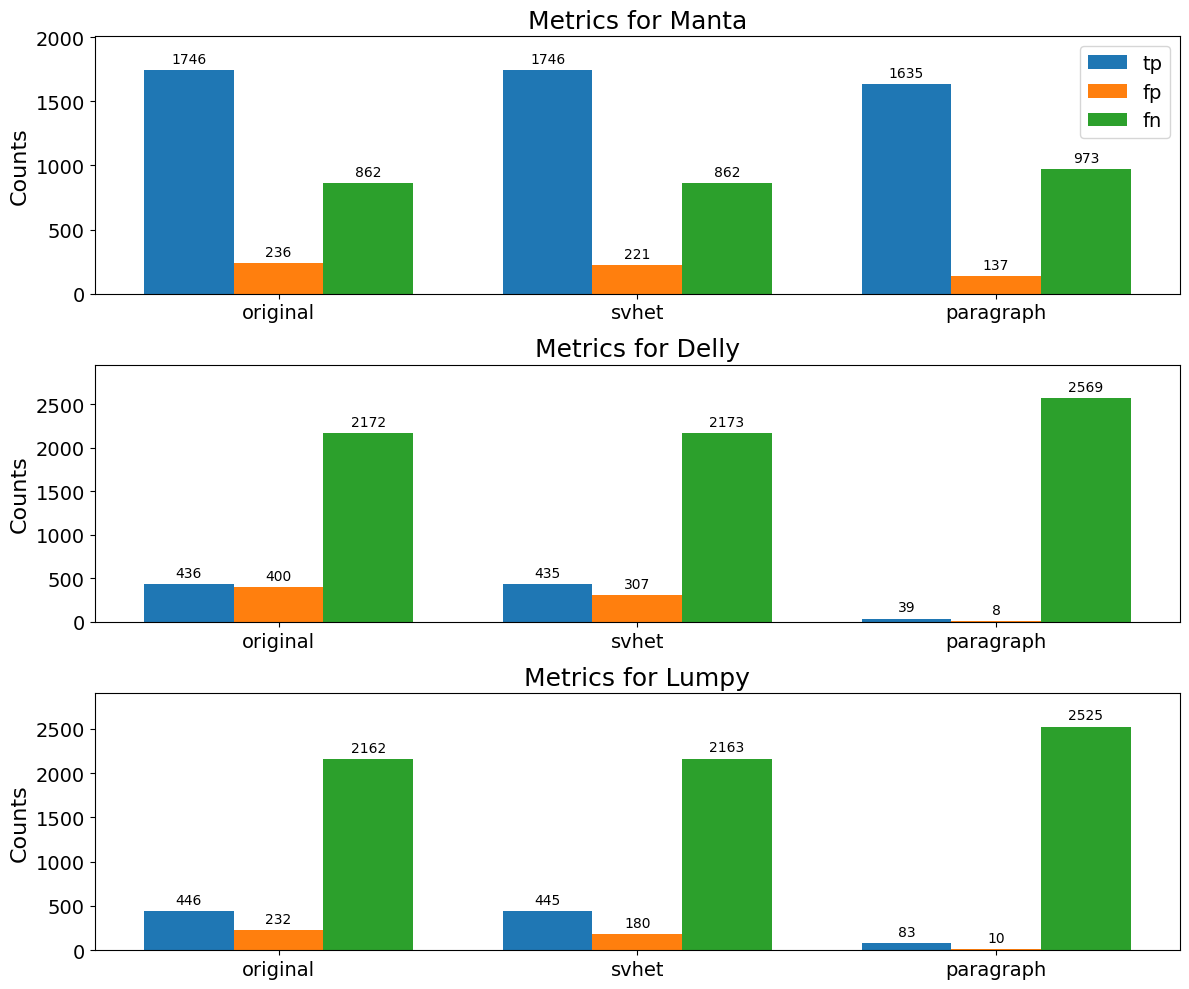

In [200]:
df = pd.DataFrame.from_dict(results, orient="index")

colors = {'tp': '#1f77b4', 'fp': '#ff7f0e', 'fn': '#2ca02c'}

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=False)

metric_groups = ['cand', 'svhet', 'paragraph']

for i, caller in enumerate(df.index):
    ax = axes[i]
    
    cand_data = [df.loc[caller, 'tp-cand'], df.loc[caller, 'fp-cand'], df.loc[caller, 'fn-cand']]
    svhet_data = [df.loc[caller, 'tp-svhet'], df.loc[caller, 'fp-svhet'], df.loc[caller, 'fn-svhet']]
    paragraph_data = [df.loc[caller, 'tp-paragraph'], df.loc[caller, 'fp-paragraph'], df.loc[caller, 'fn-paragraph']]
    
    x = np.arange(3) 
    width = 0.25 
    
    bars_tp = ax.bar(x - width, [cand_data[0], svhet_data[0], paragraph_data[0]], width, 
           label='tp' if i == 0 else "", color=colors['tp'])
    bars_fp = ax.bar(x, [cand_data[1], svhet_data[1], paragraph_data[1]], width, 
           label='fp' if i == 0 else "", color=colors['fp'])
    bars_fn = ax.bar(x + width, [cand_data[2], svhet_data[2], paragraph_data[2]], width, 
           label='fn' if i == 0 else "", color=colors['fn'])
    
    all_values = cand_data + svhet_data + paragraph_data
    max_value = max(all_values)
    ax.set_ylim(0, max_value * 1.15)
    
    for bars in [bars_tp, bars_fp, bars_fn]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    ax.set_title(f'Metrics for {caller.capitalize()}')
    ax.set_ylabel('Counts')
    ax.set_xticks(x)
    ax.set_xticklabels(['original', 'svhet', 'paragraph'])
    ax.grid(False)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(fig_out, 'Figure 2.png'), dpi=300, bbox_inches='tight')

In [207]:
result3 = pd.concat([
    pd.json_normalize(results["manta"]),
    pd.json_normalize(results["delly"]),
    pd.json_normalize(results["lumpy"])
])

result3.index = ['manta', 'delly', 'lumpy']
result3["precision_before"] = result3["tp-cand"] / (result3["tp-cand"] + result3["fp-cand"])
result3["recall_before"] = result3["tp-cand"] / (result3["tp-cand"] + result3["fn-cand"])
result3["precision_svhet"] = result3["tp-svhet"] / (result3["tp-svhet"] + result3["fp-svhet"])
result3["recall_svhet"] = result3["tp-svhet"] / (result3["tp-svhet"] + result3["fn-svhet"])
result3["precision_paragraph"] = result3["tp-paragraph"] / (result3["tp-paragraph"] + result3["fp-paragraph"])
result3["recall_paragraph"] = result3["tp-paragraph"] / (result3["tp-paragraph"] + result3["fn-paragraph"])
result3["FS_svhet"] = ((result3["fp-cand"] - result3["fp-svhet"]) / (result3["fp-cand"] - result3["fp-svhet"] + result3["tp-cand"] - result3["tp-svhet"])).round(3)
result3["FS_paragraph"] = ((result3["fp-cand"] - result3["fp-paragraph"]) / (result3["fp-cand"] - result3["fp-paragraph"] + result3["tp-cand"] - result3["tp-paragraph"])).round(3)

selected = (result3.iloc[:, 9:] * 100).round(1)
selected.columns = ['Original Prec (%)', 'Original Rec (%)', 'SVhet Prec (%)', 'SVhet Rec (%)',
                    'Paragraph Prec (%)', 'Paragraph Rec (%)', 'SVhet Acc (%)', 'Paragraph Acc (%)']
selected

,Original Prec (%),Original Rec (%),SVhet Prec (%),SVhet Rec (%),Paragraph Prec (%),Paragraph Rec (%),SVhet Acc (%),Paragraph Acc (%)
manta,88.1,66.9,88.8,66.9,92.3,62.7,100.0,47.1
delly,52.2,16.7,58.6,16.7,83.0,1.5,98.9,49.7
lumpy,65.8,17.1,71.2,17.1,89.2,3.2,98.1,37.9


### Time profiles

In [208]:
import re

def extract_walltime_peak_rss(file_path: str):

    walltime_minutes = None
    peak_rss_gb = None
    
    try:
        with open(file_path, 'r') as file:
            time_output = file.read()
        
        # Extract elapsed (wall clock) time in format h:mm:ss or m:ss
        walltime_match = re.search(r'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): ([0-9:.]+)', time_output)
        if walltime_match:
            time_str = walltime_match.group(1)
            
            # Convert time string to total minutes
            parts = time_str.split(':')
            if len(parts) == 3:  # h:mm:ss format
                hours = int(parts[0])
                minutes = int(parts[1])
                seconds = float(parts[2])
                walltime_minutes = (hours * 60) + minutes + (seconds / 60)
            elif len(parts) == 2:  # m:ss format
                minutes = int(parts[0])
                seconds = float(parts[1])
                walltime_minutes = minutes + (seconds / 60)
            else:
                raise ValueError(f"Invalid time format: {time_str}")
        
        # Extract Maximum resident set size (kbytes) and convert to GB
        peak_rss_match = re.search(r'Maximum resident set size \(kbytes\): (\d+)', time_output)
        if peak_rss_match:
            peak_rss_kb = int(peak_rss_match.group(1))
            peak_rss_gb = peak_rss_kb / 1000000
            
    except Exception as e:
        return str(e), None
    
    return walltime_minutes, peak_rss_gb

In [209]:
time_out = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/time_profiles"

time_dict = {}
memory_dict = {}
for root, dirs, files in os.walk(time_out):
    for file in files:
        if not "150bp" in file:
            continue
        
        fp = os.path.join(root, file)
        time, rss = extract_walltime_peak_rss(fp)
        
        if "60x" in file:
            _, bench, caller, *_ = file.split("_")
            if bench == "both":
                continue
            
            time_dict.setdefault("60x", {}).setdefault(bench, {})
            memory_dict.setdefault("60x", {}).setdefault(bench, {})
            time_dict["60x"][bench][caller] = time
            memory_dict["60x"][bench][caller] = rss
        elif "30x" in file or "20x" in file:
            _, caller, _, depth = file.removesuffix(".txt").split("_")
            
            time_dict.setdefault(depth, {}).setdefault("either", {})
            memory_dict.setdefault(depth, {}).setdefault("either", {})
            time_dict[depth]["either"][caller] = time
            memory_dict[depth]["either"][caller] = rss

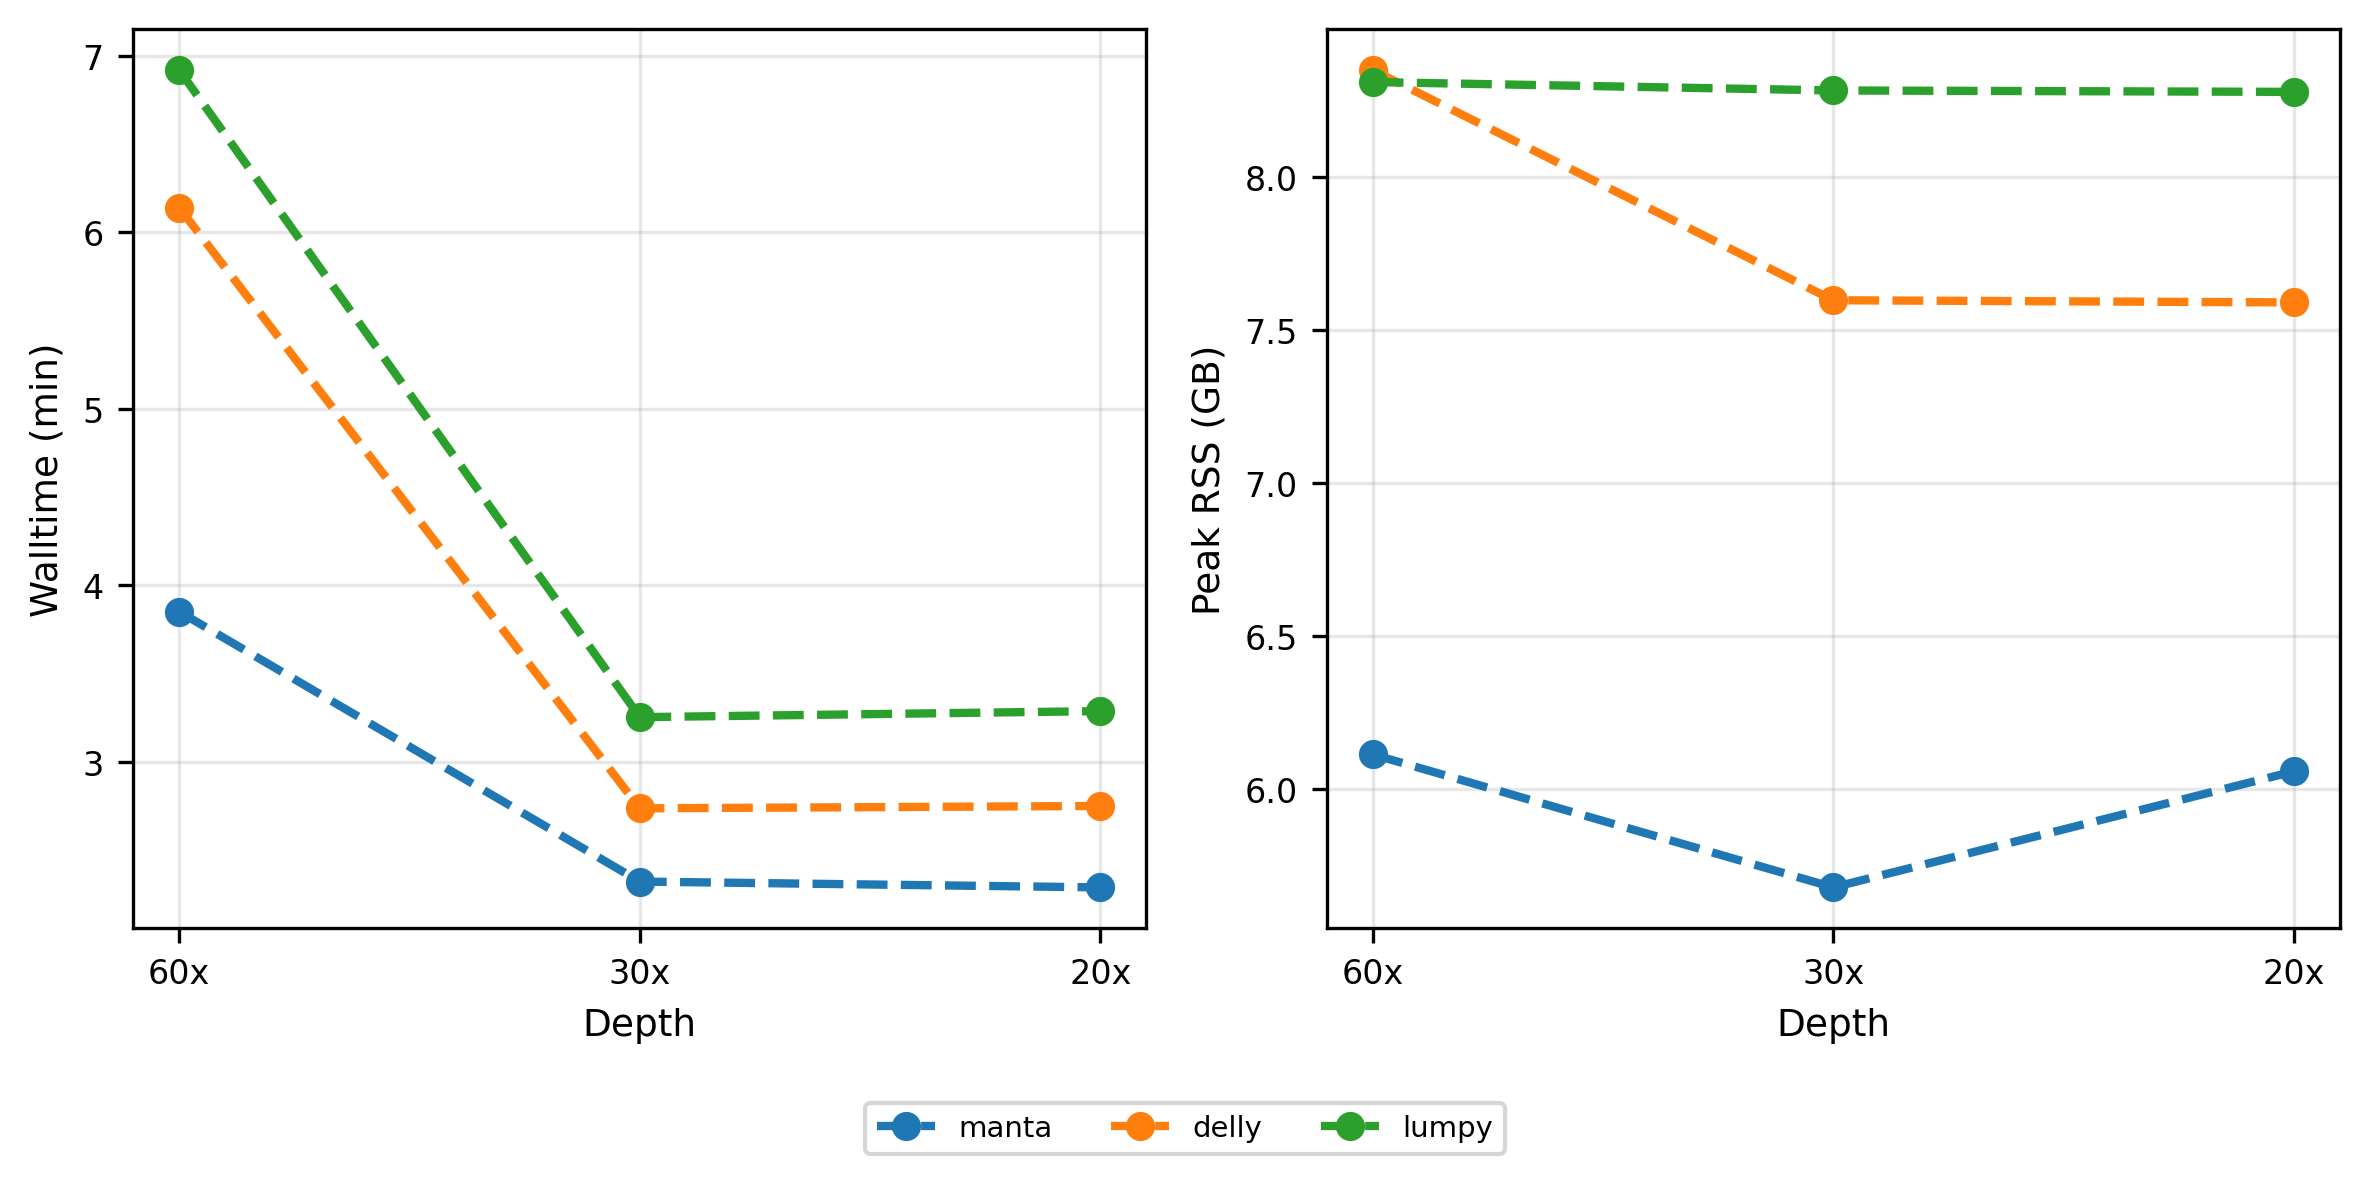

In [217]:
plt.rcParams['axes.titlesize'] = 18      
plt.rcParams['axes.labelsize'] = 9 
plt.rcParams['xtick.labelsize'] = 8  
plt.rcParams['ytick.labelsize'] = 8   
plt.rcParams['figure.titlesize'] = 20  
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['legend.title_fontsize'] = 16

def plot_broken_line(data, ax, ylabel=None):
    depths = data.keys()
    val = {"manta": [], "delly": [], "lumpy": []}

    for depth in depths:
        for tool in val.keys():
            val[tool].append(data[depth]["either"].get(tool, None))
            
    for tool in val.keys():
        ax.plot(depths, val[tool], linestyle='--', marker='o', label=f'{tool}', linewidth=2, markersize=6)
    ax.set_xlabel('Depth')
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
            
    return ax

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=300)

plot_broken_line(time_dict, axes[0], ylabel='Walltime (min)')
plot_broken_line(memory_dict, axes[1], ylabel='Peak RSS (GB)')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.03), ncol=3)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(fig_out, 'Figure 4.png'), dpi=300, bbox_inches='tight')
